# Classification for PSK


This notebook uses PSK and QAM families dataset for training customized EffiecientNet models. the dataset consists of 130K samples for 13 classes to be classifed, so there are 10K samples for each class

### Import Libraries

In [18]:
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import os
import shutil
from torch.utils.data import Subset
from sigPSK import Sig53
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from Train_evaluate import *
from modeling import *
from torch import nn, optim
from torchsummary import summary


----
### Data reading

In [19]:
selected_classes = [
    "bpsk",
    "qpsk",
    "8psk",
    "16psk",
    "32psk",
    ]

In [32]:
# Specify Sig53 Options
root = "../../../../data/torchsig/sigPSK/"
train = True
impaired = True
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset

train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Dataset length: 250000
Data shape: (2, 4096)
Label Index: 3
Label Class: 16psk


In [25]:
sig53 = Sig53(
    root=root,
    train=False,
    impaired=impaired,
    transform=None,
    target_transform=None,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(sig53))
data, (label, snr) = sig53[idx]
print("Dataset length: {}".format(len(sig53)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))
print("SNR: {}".format(snr))

Dataset length: 10000
Data shape: (4096,)
Label Index: 1
Label Class: qpsk
SNR: 2.991877052995722


----
### Dataloaders

In [4]:
# Calculate the size of the validation set (10% of the training set)
val_size = int(0.1 * len(sig53_clean_train))
train_size = len(sig53_clean_train) - val_size

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sig53_clean_train, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

In [6]:
inputs, _ = next(iter(train_dataloader))
input_size = inputs.shape[1:]

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNet1D(Bottleneck1D, [1, 2, 2, 1], num_classes=len(selected_classes), in_channels=2).to(device)

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [7]:


# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
num_epochs = 20

# Assuming you have a ModelTrainer class defined that can handle the training process
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

summary(model, input_size=input_size, device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 2048]             448
       BatchNorm1d-2             [-1, 32, 2048]              64
            Conv1d-3             [-1, 32, 2048]           1,024
       BatchNorm1d-4             [-1, 32, 2048]              64
            Conv1d-5             [-1, 32, 2048]              96
            Conv1d-6             [-1, 32, 2048]           1,024
DepthwiseSeparableConv1d-7             [-1, 32, 2048]               0
       BatchNorm1d-8             [-1, 32, 2048]              64
            Conv1d-9            [-1, 128, 2048]           4,096
      BatchNorm1d-10            [-1, 128, 2048]             256
AdaptiveAvgPool1d-11               [-1, 128, 1]               0
           Linear-12                    [-1, 8]           1,024
             ReLU-13                    [-1, 8]               0
           Linear-14             

In [8]:
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 3515/3515 [05:47<00:00, 10.13it/s, loss=1.0893, accuracy=45.38%]


Epoch 1: Train Loss 1.0893, Acc 45.38%, Val Loss 4.3089, Val Acc 24.47%
Epoch 2/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.14it/s, loss=0.8499, accuracy=56.23%]


Epoch 2: Train Loss 0.8499, Acc 56.23%, Val Loss 0.9034, Val Acc 54.82%
Epoch 3/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.7987, accuracy=57.96%]


Epoch 3: Train Loss 0.7987, Acc 57.96%, Val Loss 0.8401, Val Acc 57.03%
Epoch 4/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.7740, accuracy=58.75%]


Epoch 4: Train Loss 0.7740, Acc 58.75%, Val Loss 0.7794, Val Acc 57.62%
Epoch 5/20


Training: 100%|██████████| 3515/3515 [05:50<00:00, 10.04it/s, loss=0.7598, accuracy=59.33%]


Epoch 5: Train Loss 0.7598, Acc 59.33%, Val Loss 0.7488, Val Acc 59.62%
Epoch 6/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.17it/s, loss=0.7476, accuracy=59.79%]


Epoch 6: Train Loss 0.7476, Acc 59.79%, Val Loss 0.7529, Val Acc 59.39%
Epoch 7/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.7393, accuracy=60.08%]


Epoch 7: Train Loss 0.7390, Acc 60.08%, Val Loss 0.7988, Val Acc 58.55%
Epoch 8/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.14it/s, loss=0.7308, accuracy=60.46%]


Epoch 8: Train Loss 0.7306, Acc 60.46%, Val Loss 0.7770, Val Acc 59.06%
Epoch 9/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.17it/s, loss=0.7233, accuracy=60.74%]


Epoch 9: Train Loss 0.7233, Acc 60.74%, Val Loss 0.7375, Val Acc 60.03%
Epoch 10/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.16it/s, loss=0.7193, accuracy=60.88%]


Epoch 10: Train Loss 0.7193, Acc 60.88%, Val Loss 0.7203, Val Acc 61.50%
Epoch 11/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.7149, accuracy=60.93%]


Epoch 11: Train Loss 0.7149, Acc 60.93%, Val Loss 0.7133, Val Acc 60.91%
Epoch 12/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.16it/s, loss=0.7101, accuracy=61.29%]


Epoch 12: Train Loss 0.7101, Acc 61.29%, Val Loss 0.7053, Val Acc 61.22%
Epoch 13/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.16it/s, loss=0.7061, accuracy=61.30%]


Epoch 13: Train Loss 0.7061, Acc 61.30%, Val Loss 0.7081, Val Acc 61.05%
Epoch 14/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.16it/s, loss=0.7031, accuracy=61.57%]


Epoch 14: Train Loss 0.7029, Acc 61.57%, Val Loss 0.7226, Val Acc 60.56%
Epoch 15/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.7010, accuracy=61.58%]


Epoch 15: Train Loss 0.7008, Acc 61.58%, Val Loss 0.7027, Val Acc 61.54%
Epoch 16/20


Training: 100%|██████████| 3515/3515 [05:45<00:00, 10.16it/s, loss=0.6976, accuracy=61.62%]


Epoch 16: Train Loss 0.6976, Acc 61.62%, Val Loss 0.6991, Val Acc 61.30%
Epoch 17/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.14it/s, loss=0.6957, accuracy=61.83%]


Epoch 17: Train Loss 0.6957, Acc 61.83%, Val Loss 0.7003, Val Acc 61.90%
Epoch 18/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.6930, accuracy=61.97%]


Epoch 18: Train Loss 0.6930, Acc 61.97%, Val Loss 0.6997, Val Acc 61.58%
Epoch 19/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.15it/s, loss=0.6911, accuracy=61.94%]


Epoch 19: Train Loss 0.6909, Acc 61.94%, Val Loss 0.7071, Val Acc 61.12%
Epoch 20/20


Training: 100%|██████████| 3515/3515 [05:46<00:00, 10.16it/s, loss=0.6894, accuracy=61.97%]


Epoch 20: Train Loss 0.6892, Acc 61.97%, Val Loss 0.7241, Val Acc 61.09%
Loaded best model from best_model_checkpoint.pth


----
### Call and Train Model
Loading the model structure to be trained

----
### Evaluation

Validation Loss: 0.7003
Validation Accuracy: 61.90%
Average Inference Time per Batch: 0.0177 seconds


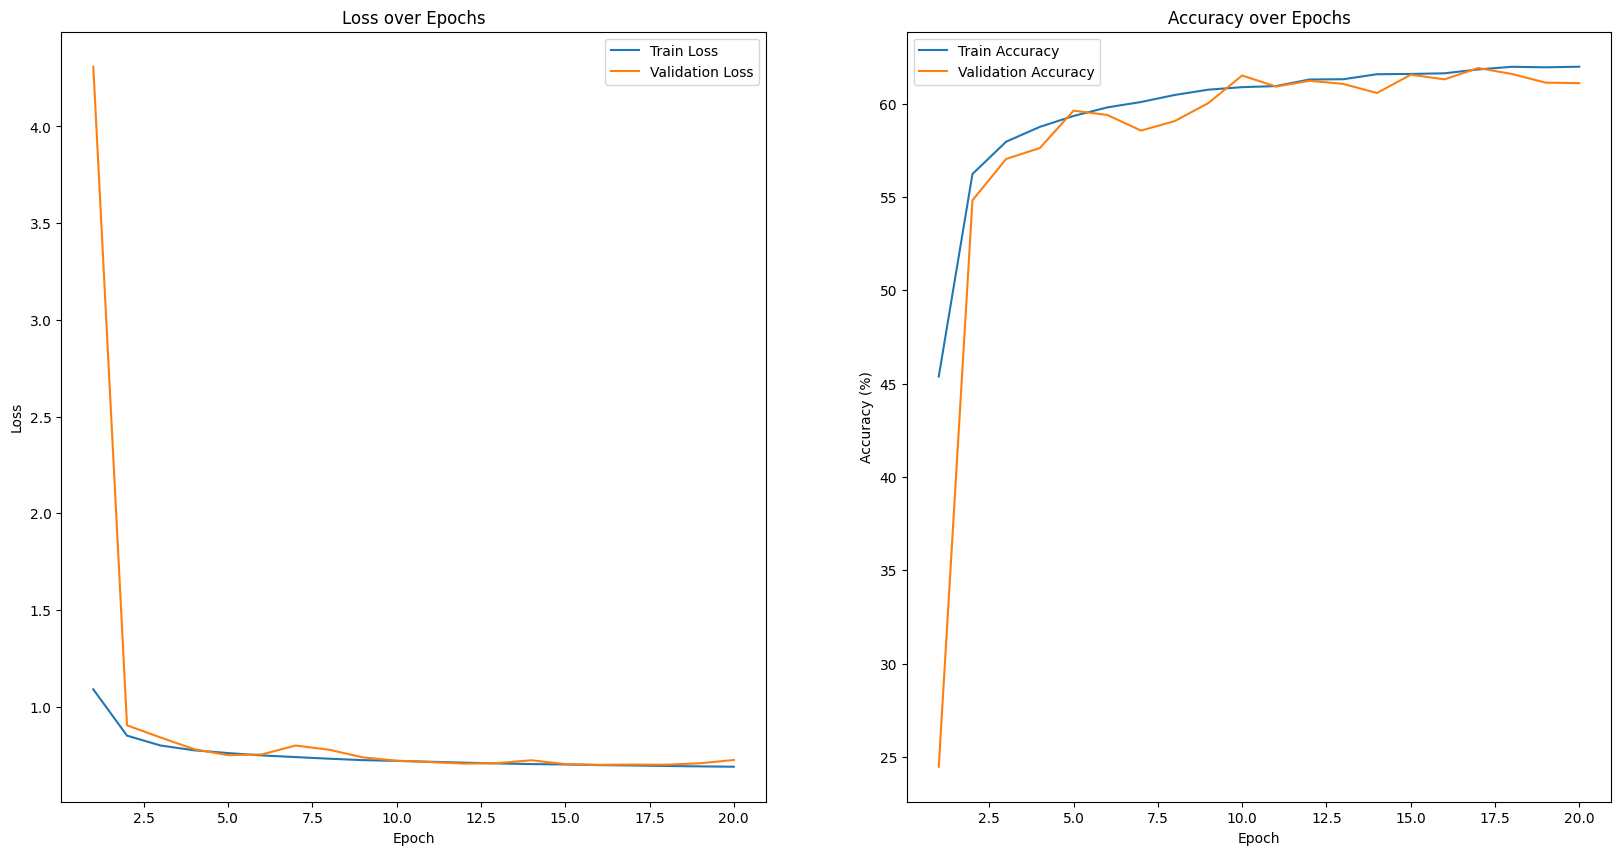

<Figure size 1500x1500 with 0 Axes>

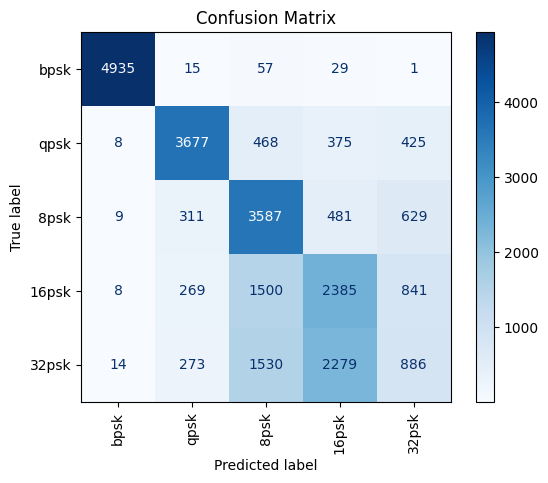

In [9]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [11]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNet1D(Bottleneck1D, [3,4,4,3], num_classes=len(selected_classes), in_channels=2).to(device)

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
num_epochs = 20

# Assuming you have a ModelTrainer class defined that can handle the training process
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

summary(model, input_size=input_size, device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 2048]             448
       BatchNorm1d-2             [-1, 32, 2048]              64
            Conv1d-3             [-1, 32, 2048]           1,024
       BatchNorm1d-4             [-1, 32, 2048]              64
            Conv1d-5             [-1, 32, 2048]              96
            Conv1d-6             [-1, 32, 2048]           1,024
DepthwiseSeparableConv1d-7             [-1, 32, 2048]               0
       BatchNorm1d-8             [-1, 32, 2048]              64
            Conv1d-9            [-1, 128, 2048]           4,096
      BatchNorm1d-10            [-1, 128, 2048]             256
AdaptiveAvgPool1d-11               [-1, 128, 1]               0
           Linear-12                    [-1, 8]           1,024
             ReLU-13                    [-1, 8]               0
           Linear-14             

In [12]:
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=1.1158, accuracy=44.09%]


Epoch 1: Train Loss 1.1158, Acc 44.09%, Val Loss 0.9866, Val Acc 51.88%
Epoch 2/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.15it/s, loss=0.8382, accuracy=56.55%]


Epoch 2: Train Loss 0.8382, Acc 56.55%, Val Loss 0.8358, Val Acc 56.82%
Epoch 3/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7910, accuracy=58.14%]


Epoch 3: Train Loss 0.7910, Acc 58.14%, Val Loss 0.7894, Val Acc 57.90%
Epoch 4/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.15it/s, loss=0.7642, accuracy=59.29%]


Epoch 4: Train Loss 0.7642, Acc 59.29%, Val Loss 0.8297, Val Acc 57.05%
Epoch 5/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7481, accuracy=59.76%]


Epoch 5: Train Loss 0.7481, Acc 59.76%, Val Loss 0.9306, Val Acc 55.56%
Epoch 6/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7365, accuracy=60.15%]


Epoch 6: Train Loss 0.7365, Acc 60.15%, Val Loss 0.7621, Val Acc 59.57%
Epoch 7/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7263, accuracy=60.72%]


Epoch 7: Train Loss 0.7263, Acc 60.72%, Val Loss 0.7633, Val Acc 60.17%
Epoch 8/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.15it/s, loss=0.7179, accuracy=60.93%]


Epoch 8: Train Loss 0.7179, Acc 60.93%, Val Loss 0.7166, Val Acc 61.30%
Epoch 9/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7123, accuracy=61.05%]


Epoch 9: Train Loss 0.7123, Acc 61.05%, Val Loss 0.7206, Val Acc 60.80%
Epoch 10/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7069, accuracy=61.29%]


Epoch 10: Train Loss 0.7069, Acc 61.29%, Val Loss 0.7075, Val Acc 61.24%
Epoch 11/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.7014, accuracy=61.49%]


Epoch 11: Train Loss 0.7014, Acc 61.49%, Val Loss 0.6985, Val Acc 61.24%
Epoch 12/20


Training: 100%|██████████| 3515/3515 [11:24<00:00,  5.14it/s, loss=0.6972, accuracy=61.74%]


Epoch 12: Train Loss 0.6972, Acc 61.74%, Val Loss 0.7136, Val Acc 61.23%
Epoch 13/20


Training: 100%|██████████| 3515/3515 [11:24<00:00,  5.14it/s, loss=0.6939, accuracy=61.81%]


Epoch 13: Train Loss 0.6939, Acc 61.81%, Val Loss 0.7098, Val Acc 61.78%
Epoch 14/20


Training: 100%|██████████| 3515/3515 [11:24<00:00,  5.14it/s, loss=0.6897, accuracy=61.97%]


Epoch 14: Train Loss 0.6897, Acc 61.97%, Val Loss 0.6943, Val Acc 61.29%
Epoch 15/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6874, accuracy=61.91%]


Epoch 15: Train Loss 0.6874, Acc 61.91%, Val Loss 0.6896, Val Acc 61.60%
Epoch 16/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6846, accuracy=62.19%]


Epoch 16: Train Loss 0.6846, Acc 62.19%, Val Loss 0.7008, Val Acc 61.42%
Epoch 17/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6811, accuracy=62.31%]


Epoch 17: Train Loss 0.6811, Acc 62.31%, Val Loss 0.6845, Val Acc 61.78%
Epoch 18/20


Training: 100%|██████████| 3515/3515 [11:24<00:00,  5.14it/s, loss=0.6805, accuracy=62.36%]


Epoch 18: Train Loss 0.6805, Acc 62.36%, Val Loss 0.6794, Val Acc 62.10%
Epoch 19/20


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6780, accuracy=62.42%]


Epoch 19: Train Loss 0.6780, Acc 62.42%, Val Loss 0.6834, Val Acc 61.82%
Epoch 20/20


Training: 100%|██████████| 3515/3515 [11:25<00:00,  5.12it/s, loss=0.6749, accuracy=62.66%]


Epoch 20: Train Loss 0.6749, Acc 62.66%, Val Loss 0.6780, Val Acc 62.42%
Loaded best model from best_model_checkpoint.pth


Validation Loss: 0.6780
Validation Accuracy: 62.42%
Average Inference Time per Batch: 0.0200 seconds


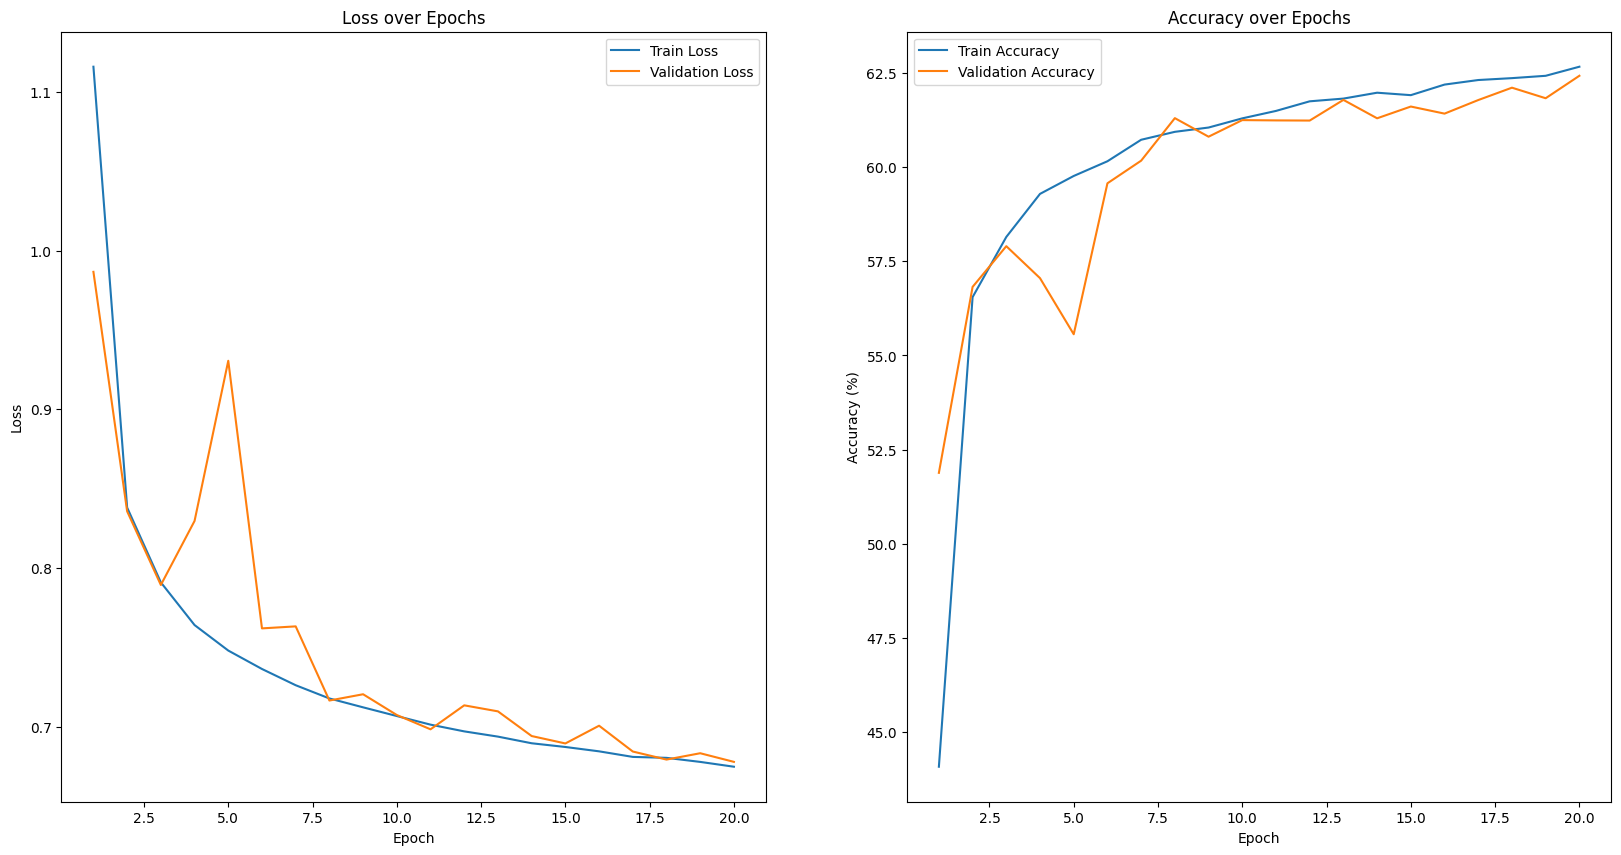

<Figure size 1500x1500 with 0 Axes>

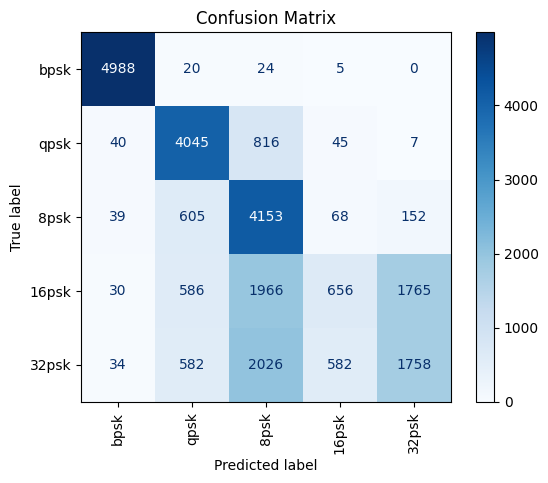

In [13]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [14]:
trainer.run_training_loop(10)

Epoch 1/10


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=0.6725, accuracy=62.79%]


Epoch 1: Train Loss 0.6725, Acc 62.79%, Val Loss 0.6723, Val Acc 62.76%
Epoch 2/10


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=0.6703, accuracy=63.01%]


Epoch 2: Train Loss 0.6703, Acc 63.01%, Val Loss 0.7288, Val Acc 61.21%
Epoch 3/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6620, accuracy=63.99%]


Epoch 3: Train Loss 0.6620, Acc 63.99%, Val Loss 0.6947, Val Acc 64.16%
Epoch 4/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.15it/s, loss=0.6379, accuracy=66.13%]


Epoch 4: Train Loss 0.6379, Acc 66.13%, Val Loss 0.6619, Val Acc 65.03%
Epoch 5/10


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=0.6259, accuracy=66.87%]


Epoch 5: Train Loss 0.6259, Acc 66.87%, Val Loss 0.8034, Val Acc 63.34%
Epoch 6/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6192, accuracy=67.08%]


Epoch 6: Train Loss 0.6192, Acc 67.08%, Val Loss 0.6664, Val Acc 65.81%
Epoch 7/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6150, accuracy=67.34%]


Epoch 7: Train Loss 0.6150, Acc 67.34%, Val Loss 0.6358, Val Acc 66.22%
Epoch 8/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6122, accuracy=67.57%]


Epoch 8: Train Loss 0.6122, Acc 67.57%, Val Loss 0.6386, Val Acc 66.51%
Epoch 9/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6087, accuracy=67.79%]


Epoch 9: Train Loss 0.6087, Acc 67.79%, Val Loss 0.6265, Val Acc 66.97%
Epoch 10/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.15it/s, loss=0.6081, accuracy=67.77%]


Epoch 10: Train Loss 0.6081, Acc 67.77%, Val Loss 0.6149, Val Acc 66.96%
Loaded best model from best_model_checkpoint.pth


In [15]:
trainer.run_training_loop(10)

Epoch 1/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.6072, accuracy=67.81%]


Epoch 1: Train Loss 0.6072, Acc 67.81%, Val Loss 0.6184, Val Acc 66.72%
Epoch 2/10


Training: 100%|██████████| 3515/3515 [11:25<00:00,  5.12it/s, loss=0.6041, accuracy=67.88%]


Epoch 2: Train Loss 0.6041, Acc 67.88%, Val Loss 0.6204, Val Acc 67.02%
Epoch 3/10


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=0.6028, accuracy=68.13%]


Epoch 3: Train Loss 0.6028, Acc 68.13%, Val Loss 0.6113, Val Acc 67.73%
Epoch 4/10


Training: 100%|██████████| 3515/3515 [11:22<00:00,  5.15it/s, loss=0.5999, accuracy=68.37%]


Epoch 4: Train Loss 0.5999, Acc 68.37%, Val Loss 0.6112, Val Acc 67.36%
Epoch 5/10


Training: 100%|██████████| 3515/3515 [11:24<00:00,  5.13it/s, loss=0.5990, accuracy=68.32%]


Epoch 5: Train Loss 0.5990, Acc 68.32%, Val Loss 0.6181, Val Acc 67.36%
Epoch 6/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.5961, accuracy=68.52%]


Epoch 6: Train Loss 0.5961, Acc 68.52%, Val Loss 0.6189, Val Acc 67.20%
Epoch 7/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.5937, accuracy=68.68%]


Epoch 7: Train Loss 0.5937, Acc 68.68%, Val Loss 0.6137, Val Acc 67.35%
Epoch 8/10


Training: 100%|██████████| 3515/3515 [11:23<00:00,  5.14it/s, loss=0.5920, accuracy=68.86%]


Epoch 8: Train Loss 0.5920, Acc 68.86%, Val Loss 0.6115, Val Acc 67.57%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


Validation Loss: 0.6113
Validation Accuracy: 67.73%
Average Inference Time per Batch: 0.0202 seconds


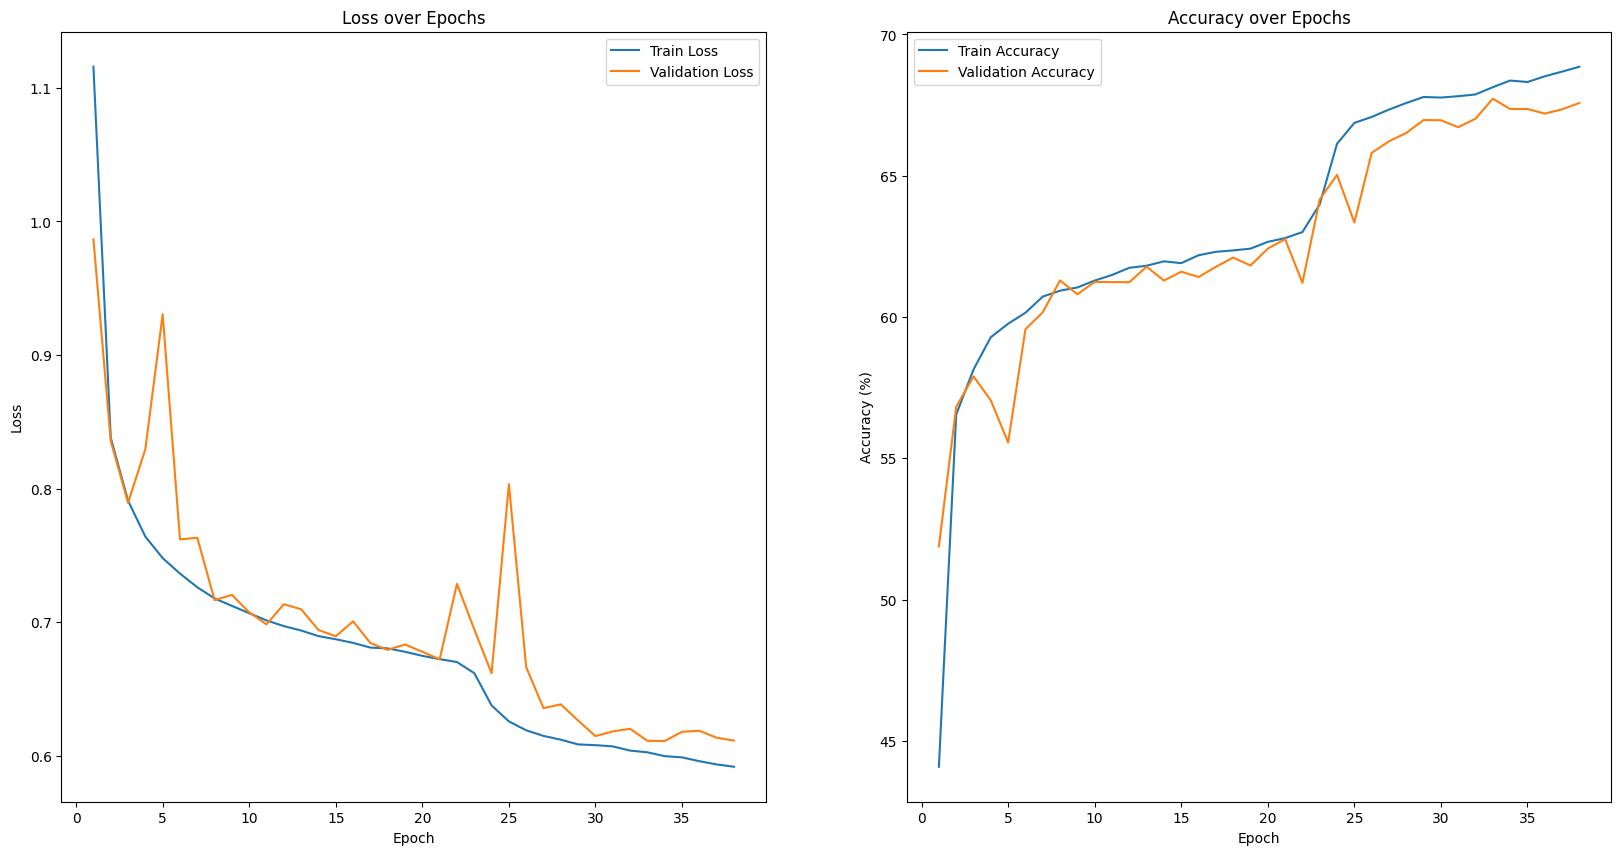

<Figure size 1500x1500 with 0 Axes>

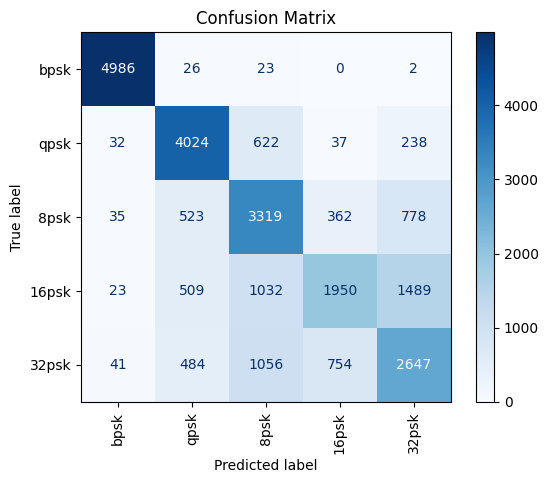

In [16]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [17]:
torch.save(trainer.model.state_dict(), './models/PSK_im_new_m')

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNet1D(Bottleneck1D, [3,4,4,3], num_classes=len(selected_classes), in_channels=2).to(device)

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

state_dict = torch.load('./models/PSK_im_new_m')
model.load_state_dict(state_dict)

<All keys matched successfully>

### Accuracy based on SNR

In [42]:
def get_snr_bin(snr):
    if snr <= 5:
        return '-2 to 5'
    elif 6 <= snr <= 10:
        return '6 to 10'
    elif 11 <= snr <= 15:
        return '11 to 15'
    elif 16 <= snr <= 20:
        return '16 to 20'
    elif 21 <= snr <= 25:
        return '21 to 25'
    elif 26 <= snr <= 30:
        return '26 to 30'


In [31]:
sig53_metadata = Sig53(
    root=root,
    train=False,
    impaired=impaired,
    transform=None,
    target_transform=None,
)

In [43]:
from collections import defaultdict
# Evaluation per SNR bin
model.eval()
model.to(device)
snr_bins = defaultdict(lambda: {'correct': 0, 'total': 0})

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_dataloader):
        # Get corresponding SNR values from the metadata
        start_idx = batch_idx * 16
        end_idx = start_idx + 16
        snrs = [sig53_metadata[idx][1][1] for idx in range(start_idx, end_idx)]

        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for label, pred, snr in zip(labels, predicted, snrs):
            bin_name = get_snr_bin(snr)
            snr_bins[bin_name]['total'] += 1
            if label == pred:
                snr_bins[bin_name]['correct'] += 1

# Define the bin order
bin_order = ['-2 to 5', '6 to 10', '11 to 15', '16 to 20', '21 to 25', '26 to 30']

# Calculate and print accuracy per SNR bin in order
for bin_name in bin_order:
    if bin_name in snr_bins:
        stats = snr_bins[bin_name]
        accuracy = 100 * stats['correct'] / stats['total']
        count = stats['total']
        print(f"SNR Bin {bin_name}: Accuracy = {accuracy:.2f}% (Count = {count})")
    else:
        print(f"SNR Bin {bin_name}: No data available")


SNR Bin -2 to 5: Accuracy = 40.41% (Count = 2316)
SNR Bin 6 to 10: Accuracy = 51.58% (Count = 1140)
SNR Bin 11 to 15: Accuracy = 69.57% (Count = 1288)
SNR Bin 16 to 20: Accuracy = 79.31% (Count = 1252)
SNR Bin 21 to 25: Accuracy = 86.71% (Count = 1204)
SNR Bin 26 to 30: Accuracy = 88.64% (Count = 1312)


: 